In [1]:
import os   # 디렉토리 경로 호출 용도 
import cv2   # 이미지 파일 불러올 때 사용
import numpy as np  # 다양한 행렬 연산 (데이터 처리) 용도
from sklearn.preprocessing import LabelEncoder  
# 데이터 전처리 (문자로된 폴더 리스트를 숫자형 array로 변환)
from sklearn.preprocessing import OneHotEncoder
#one-hot-encoding을 위해 OneHotEncoder 함수를 불러옴
from numpy import array # 리스트를 array형태로 만들떄 사용하는 함수
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tf.set_random_seed(1)

In [2]:
tf.reset_default_graph()  # 이전에 생성해둔 graph, variable 모두 초기된다.

TRAIN_DIR = 'E:\\data\\vinzip\\trainingSet\\'
train_folder_list = array(os.listdir(TRAIN_DIR))
train_input = []
train_label = []
 
label_encoder = LabelEncoder()  # LabelEncoder Class 호출

integer_encoded = label_encoder.fit_transform(train_folder_list)  ###[0 1 2]

#문자열로 구성된 train_folder_list를 숫자형 리스트로 변환

onehot_encoder = OneHotEncoder(sparse=False) 
#print(onehot_encoder)
#OneHotEncoder(categorical_features=None, categories=None,dtype=<class 'numpy.float64'>, handle_unknown='error', n_values=None, sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)  ## [[0][1][2]]

onehot_encoded = onehot_encoder.fit_transform(integer_encoded)   ## [[1. 0. 0.] [0. 1. 0.] [0. 0. 1.]]


for index in range(len(train_folder_list)):
    path = os.path.join(TRAIN_DIR, train_folder_list[index])
    path = path + '\\' 
    img_list = os.listdir(path) # <- img_1.jpg img_2.jpg....
    for img in img_list:
        img_path = os.path.join(path, img) # E:\data\MNIST\trainingSet\0_zero\ + img_1.jpg 
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 이미지를 불러옴
        train_input.append([np.array(img)]) # 불러온 이미지를 array로 바꿔서 append
        train_label.append([np.array(onehot_encoded[index])]) # one_hot 한 라벨도 append

train_input = np.reshape(train_input, (-1,4096))  # (3800, 4096)
train_label = np.reshape(train_label, (-1, 3))  # (3800, 3)

train_input = np.array(train_input).astype(np.float32) # (3800, 4096) => 2차원 배열로 배열안에 각각 이미지가 행렬 형태로 저장됨
train_label = np.array(train_label).astype(np.float32) # (3800,3) => 2차원 배열로 배열안에 라벨 값이 행렬 형태로 저장됨 [[0 0 1] [1 0 0 ]..]

TEST_DIR ='E:\\data\\vinzip\\testSet\\'
test_folder_list = array(os.listdir(TEST_DIR))
 
test_input = []
test_label = []
 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(test_folder_list)
 
onehot_encoder = OneHotEncoder(sparse=False) 
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
 
for index in range(len(test_folder_list)):
    path = os.path.join(TEST_DIR, test_folder_list[index])
    path = path + '\\'
    img_list = os.listdir(path)
    for img in img_list:
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_input.append([np.array(img)])
        test_label.append([np.array(onehot_encoded[index])])
 
test_input = np.reshape(test_input, (-1, 4096))
test_label = np.reshape(test_label, (-1, 3))
test_input = np.array(test_input).astype(np.float32)
test_label = np.array(test_label).astype(np.float32)
# np.save("test_input.npy",test_input)
# np.save("test_label.npy",test_label)
 
# hyper parameters
learning_rate = 0.001
 
# input place holders
X = tf.placeholder(tf.float32, [None, 4096]) 
X_img = tf.reshape(X, [-1, 64, 64, 1])   # img 28x28x1 (black/white)

'''
X라는 변수의 shape은 [-1, 4096]이므로 원래 데이터의 shape([-1, 64, 64, 1)]으로 바꾸어  
X_img에 저장한다. [-1, 64, 64, 1]에서 -1은 batch size를 뜻한다. 

batch size는 가변할 수 있으므로 대부분 -1로 지정한다. 64, 64는 이미지의 너비와 높이를 
의미한다. 

마지막의 1은 이미지의 channel 수를 의미한다. grayscale로 이미지를 
불러왔으므로 1로 설정되었으며, RGB로 불러왔을 경우에는 3을 기입해야한다.
'''

Y = tf.placeholder(tf.float32, [None, 3])

keep_prob = tf.placeholder(tf.float32)

 
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))

'''
필터의 [가로,세로,채널,개수]
Convolution layer의 필터 크기와 개수를 선언하여 W1에 저장한다. 
tf.random_normal[3, 3, 1, 32]에서 tf.random_normal은 정규분포에서 난수를 추출하여 저장한다는 의미이며, 
3,3은 필터 크기 즉, 3*3필터를 쓰겠다고 선언한 것이며, 1은 input data의 channel인 1을 지정했다. 
마지막 32는 3*3필터를 총 32개 쓰겠다고 선언한 것.
'''

L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
# [64,64,1] --> [64,64,32] (32개의 featuremap을 가짐)
    
'''
 Convoluton layer를 선언하여 L1에 저장한다. 
 X_img는 해당 Convolution layer의 input이며, W1은 앞서 선언한 Convolution layer의 필터이다.
 즉, X_img에 W1 필터를 활용하여 Convolution layer를 구성하겠다는 뜻이다.
 
 padding=’SAME’은 convolution 연산 후 shape이 줄어드는 것을 방지하기 위하여 설정하는 구문이다. 
 만약 padding=’VALID’로 설정한다면,3*3필터가 64*64 이미지를 한칸 씩 움직이며 연산을 수행하므로 
 convoultion 연산 이후 출력된 결과의 shape은 64*64이 아닌 62*62가 된다.
'''

L1 = tf.nn.relu(L1) # 활성화 함수는 렐루를 사용
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
# [64,64,32] --> [32,32,32] (2x2 max_poo;ing을 거침)

#L1 = tf.nn.dropout(L1, keep_prob)

'''
ksize=[1,2,2,1]에 대한 설명은 다음과 같다. 
ksize는 kernel 사이즈를 의미하며, Conolution layer의 filter와 동일한 개념이라고 생각하면 된다. 
첫번째 1은 모든 batch에 대하여 kernel을 적적용하겠다는 의미이며, [2,2]는 2*2크기의 kernel을 사용하겠다는 의미다. 
마지막 1은 모든 채널에 대하여 kernel을 적용하겠다는 의미
'''

W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#L2 = tf.nn.dropout(L2, keep_prob)  #안쓰는게 더 정확함 


W3 = tf.Variable(tf.random_normal([3, 3, 64, 64], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob)

L3_flat = tf.reshape(L3, [-1, 8 * 8 * 64]) # 다시 평평하게

W4 = tf.get_variable("W4", shape=[8 * 8 * 64, 3], initializer=tf.contrib.layers.xavier_initializer())
                 
'''
 fully-connected 연산을 위해 weight를 선언하여 W3에 저장한다. 
 이 때, W3의 shape을 [7*7*64, 10]으로 지정했는데, input data의 shape이 7*7*64이며, 
 output data의 shape이 10(0~9)이기 때문에 W3의 shape을 [7*7*64, 10]으로 설정한다. 
 Weigth의 초기값은 성능이 우수한 것으로 알려진 Xavier initializer를 사용한다.
'''

b = tf.Variable(tf.random_normal([3]))
#bias를 선언하여 b에 저장한다. output의 shape이 10이므로 shape을 10으로 설정
logits = tf.matmul(L3_flat, W4) + b

# define cost/loss &amp;amp;amp; optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
 #cost를 최소화하는 optimizer 함수를 선언
    
training_epochs = 100
'''
 학습 횟수를 설정한다.
'''
batch_size = 600
'''
효과적인 모델 학습을 위해 batch size를 설정한다. 
batch size는 학습 할 때 몇개의 데이터를 한번에 학습하는가에 관한 설정이다. 
본 실험에서는 3,800개의 데이터를 학습하므로, batch size는 1~3,800까지 설정할 수 있다. 
600으로 설정했으므로 한번 학습하는데 600개의 데이터를 사용한다는 의미다.
'''


C:\Users\pc\Anaconda3\envs\zz\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\pc\Anaconda3\envs\zz\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In c

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



'\n효과적인 모델 학습을 위해 batch size를 설정한다. \nbatch size는 학습 할 때 몇개의 데이터를 한번에 학습하는가에 관한 설정이다. \n본 실험에서는 3,800개의 데이터를 학습하므로, batch size는 1~3,800까지 설정할 수 있다. \n600으로 설정했으므로 한번 학습하는데 600개의 데이터를 사용한다는 의미다.\n'

In [13]:
save_file = './train_model.ckpt'
saver = tf.train.Saver()


# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer()) #모든 변수의 weight값을 초기화 한다.

# result = sess.run(W1)
# print('필터',result)
# train my model
save_file = './train_model.ckpt'
train_cost_list=[]

train_acc_list = []
test_acc_list=[]

print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(len(train_input) / batch_size)
    
    '''
    1 epoch에 몇회 학습할 것인지를 설정한다. 
    train_input에 저장된 데이터는 3,800개이므로 len(train_input)은 3,800을, 
    batch_size는 600으로 설정했으므로 total_batch는 3800/600이 된다.
    '''
    batch_xs = 0
    batch_ys = 0
    for i in range(total_batch):
        start = ((i + 1) * batch_size) - batch_size # 0, 600, 1200, ..
        end = ((i + 1) * batch_size) # 200, 400, 600 ..
        batch_xs = train_input[start:end]
        batch_ys = train_label[start:end]
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
        
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    train_cost_list.append(avg_cost)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_acc = sess.run(accuracy, feed_dict={
      X: batch_xs, Y: batch_ys, keep_prob: 1})
    
    test_acc = sess.run(accuracy, feed_dict={
          X: test_input, Y: test_label, keep_prob: 1})
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

print('\n****Learning Finished! ****',end='\n\n')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: test_input, Y: test_label, keep_prob: 1}),end='\n\n')

# Save the model
saver.save(sess, save_file)
print('Trained Model Saved.')

sess.close()


Learning started. It takes sometime.
Epoch: 0001 cost = 3.859402952
Epoch: 0002 cost = 1.333543589
Epoch: 0003 cost = 1.310301746
Epoch: 0004 cost = 1.281153580
Epoch: 0005 cost = 1.195661207
Epoch: 0006 cost = 1.281343182
Epoch: 0007 cost = 1.097521991
Epoch: 0008 cost = 1.072390238
Epoch: 0009 cost = 1.035709341
Epoch: 0010 cost = 0.951775536
Epoch: 0011 cost = 0.861819511
Epoch: 0012 cost = 0.818423063
Epoch: 0013 cost = 0.777067363
Epoch: 0014 cost = 0.793574214
Epoch: 0015 cost = 0.738385990
Epoch: 0016 cost = 0.752811834
Epoch: 0017 cost = 0.688689068
Epoch: 0018 cost = 0.642041882
Epoch: 0019 cost = 0.729561316
Epoch: 0020 cost = 0.633724188
Epoch: 0021 cost = 0.583006881
Epoch: 0022 cost = 0.637068207
Epoch: 0023 cost = 0.614086658
Epoch: 0024 cost = 0.591679223
Epoch: 0025 cost = 0.654732727
Epoch: 0026 cost = 0.506485822
Epoch: 0027 cost = 0.625867844
Epoch: 0028 cost = 0.528476179
Epoch: 0029 cost = 0.511097622
Epoch: 0030 cost = 0.502590594
Epoch: 0031 cost = 0.489216175
Ep

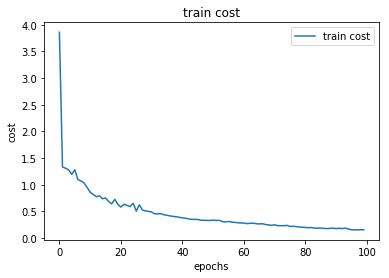

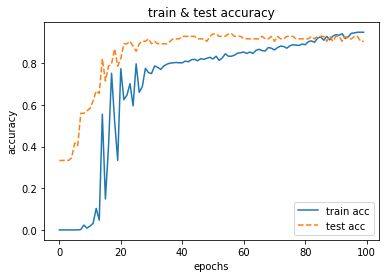

In [14]:
# 그래프 그리기
#markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_cost_list))

y = np.arange(len(train_acc_list))
z = np.arange(len(test_acc_list))

plt.plot(x, train_cost_list, label='train cost')
plt.xlabel("epochs")
plt.ylabel("cost")
#plt.ylim(0, 4.0)
plt.legend(loc='upper right')
plt.title('train cost')
plt.show()

plt.plot(y, train_acc_list, label='train acc')
plt.plot(z, test_acc_list, label='test acc', linestyle='--')
plt.title('train & test accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()


In [3]:
### 모델 로드해서 test 해보기.


TEST_DIR2 ='E:\\data\\vinzip\\testSet2\\'
test_folder_list2 = array(os.listdir(TEST_DIR2))
 
test_input2 = []
test_label2 = []
 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(test_folder_list2)
 
onehot_encoder = OneHotEncoder(sparse=False) 
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
 
for index in range(len(test_folder_list2)):
    path = os.path.join(TEST_DIR2, test_folder_list2[index])
    path = path + '\\'
    img_list = os.listdir(path)
    for img in img_list:
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_input2.append([np.array(img)])
        test_label2.append([np.array(onehot_encoded[index])])
 
test_input2 = np.reshape(test_input2, (-1, 4096))
test_label2 = np.reshape(test_label2, (-1, 3))
test_input2 = np.array(test_input2).astype(np.float32)
test_label2 = np.array(test_label2).astype(np.float32)


save_file = './train_model.ckpt'
saver = tf.train.Saver()
 
# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)
 
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    test_accuracy = sess.run(
        accuracy,
        feed_dict={X: test_input, Y: test_label, keep_prob: 1})
    

print('Test Accuracy: {}'.format(test_accuracy))

C:\Users\pc\Anaconda3\envs\zz\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


INFO:tensorflow:Restoring parameters from ./train_model.ckpt
Test Accuracy: 0.8600000143051147
